In [1]:

import pickle
import numpy as np
import math
from Camera import Camera
from Frame import Frame
import matplotlib.pyplot as plt
import Utils
%matplotlib qt


path = 'C:/Users/Roni/Documents/gs_input/frames_model.pkl'
image_path = 'C:/Users/Roni/Documents/fly'
with open(path,'rb') as f:
    frames = pickle.load(f)

frames_per_cam = [Frame(image_path,frames,900,cam_num) for cam_num in range(4)]



In [2]:
camera_pixel = np.vstack([frame.camera_center_to_pixel_ray(([frame.cm[1],frame.cm[0]])) for frame in  frames_per_cam])
camera_center = np.vstack([frame.X0.T for frame in  frames_per_cam])
# rot_mat_ew_to_lab = frames_per_cam[0].rotation_matrix_from_vectors(frames_per_cam[0].R[2,:], [0,0,1])
cm_point = Utils.triangulate_least_square(camera_center,camera_pixel)
# cm_point_lab = np.squeeze(np.dot(rot_mat_ew_to_lab,cm_point[:,np.newaxis]).T)

In [3]:
xyz = np.vstack([np.linspace(coord - 0.003,coord + 0.003,50) for coord in cm_point]).T
x,y,z = np.meshgrid(xyz[:,0],xyz[:,1],xyz[:,2])
ptcloud_volume = np.vstack([x.ravel(),y.ravel(),z.ravel()]).T
ptsv = frames_per_cam[0].homogenize_coordinate(ptcloud_volume)
pt2dv = frames_per_cam[0].project_on_image(ptsv)
pts_for_unique = np.vstack((frames_per_cam[0].pixels,np.unique(pt2dv.astype(int),axis = 0)))
v,cnt = np.unique(pts_for_unique,return_counts = True,axis = 0)
projected_on_image = v[cnt > 1]
all_indices = np.vstack(np.argwhere(np.all(pt2dv.astype(int) == repeated_group, axis=1)) for repeated_group in projected_on_image)
fly_vxls = ptcloud_volume[all_indices,:]

C:\Users\Roni\AppData\Local\Temp\ipykernel_19576\3257062134.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  all_indices = np.vstack(np.argwhere(np.all(pt2dv.astype(int) == repeated_group, axis=1)) for repeated_group in projected_on_image)


In [22]:
pts

array([[-1.23926824e-03,  2.29473224e-01,  1.54564763e-01,
         1.00000000e+00],
       [-1.42530388e-01,  1.34378169e-01, -8.33057894e-03,
         1.00000000e+00],
       [ 1.36730176e-01,  1.33893229e-01,  7.95346132e-04,
         1.00000000e+00],
       [-7.07052979e-03, -2.79823321e-04,  1.91126970e-01,
         1.00000000e+00]])

In [32]:
pt2d

array([[129.58285028,  94.23576349]])

In [ ]:
# pts = frames_per_cam[2].homogenize_coordinate(cm_point)
pt2d = frames_per_cam[1].project_on_image(np.append(cm_point,1)[:,np.newaxis].T)[0]


plt.imshow(frames_per_cam[1].im)
# plt.scatter(pt2dv[:,0],pt2dv[:,1])
plt.scatter(pt2d[1],pt2d[0])

In [89]:
np.vstack([np.argwhere(np.all(pt2dv.astype(int) == repeated_group, axis=1)) for repeated_group in projected_on_image])


array([[ 4238],
       [ 6739],
       [11740],
       ...,
       [48060],
       [55562],
       [63064]], dtype=int64)

In [16]:
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'

def scatter3d(fig,data,legend, mode = 'markers',line_dict = {},marker_dict = {}):

    marker_dict = marker_dict if 'markers' in mode else {}
    
    # Include line dict if mode includes 'lines'
    line_params = line_dict if 'lines' in mode else {}
    
      
    fig.add_trace(go.Scatter3d(
        x=data[:, 0],
        y=data[:, 1],
        z=data[:, 2],
        mode=mode,
        marker=marker_dict,
        line = line_params,
        name = legend
    ))
    
    # Update layout to set aspectmode to 'cube'
    fig.update_layout(scene=dict(
        aspectmode='data'  # Ensures x, y, z axes have the same scale
    ))
    return fig

fig = go.Figure()

scatter3d(fig,camera_center,'cam')
scatter3d(fig,camera_pixel,'pix')
# scatter3d(fig,ptcloud_volume,'vol')
# scatter3d(fig,fly_vxls,'vol')

fig.add_trace(go.Scatter3d(
    x=[cm_point[ 0]],
    y=[cm_point[ 1]],
    z=[cm_point[ 2]],
    mode='markers',
    marker={},
    line = {},
    name = 'center'
))


fig.show()


In [95]:
fly_vxls

array([[[-0.00043527, -0.00162267,  0.00848574]],

       [[-0.00043527, -0.00150022,  0.00860819]],

       [[-0.00043527, -0.00125532,  0.00873064]],

       ...,

       [[-0.00325159,  0.00058142,  0.00505717]],

       [[-0.00325159,  0.00094876,  0.00530207]],

       [[-0.00325159,  0.00131611,  0.00554696]]])

array([[-0.00121165, -0.61142572, -0.38724614]])

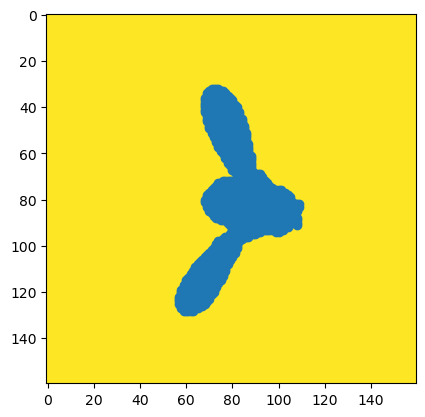

In [8]:

plt.imshow(frame.im)
plt.scatter(frame.pixels[:,1],frame.pixels[:,0])
cm = np.mean(frame.pixels,0)
frame.camera_center_to_pixel_ray(cm)



In [4]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(image_path) if isfile(join(image_path, f))]
onlyfiles

['P900CAM1.jpg.jpg',
 'P900CAM2.jpg.jpg',
 'P900CAM3.jpg.jpg',
 'P900CAM4.jpg.jpg']

In [ ]:


def triangulate_least_square(origins,end_of_vectors):
    # triangulate all lines to find the closest 3d point with least square
    # we define a 3d vector ab and a point p
    # the distance between the point and the vector: d^2 = |p-a|^2 - |(p-a).T *(b-a)/|(b-a)|^2 where (p-a).T *(b-a)/|(b-a) is the projection of ap on ab
    # d^2 = |p-a|^2 - |(p-a).T *(b-a)/|(b-a)|| = |(p-a)*(p-a).T| - |(p-a).T *(b-a)/|(b-a)||^2 = |(p-a)*(p-a).T| - |(p-a).T *n||^2 where n = (b-a)/|(b-a)|
    # we sum the squared distances and get 
    # sum(di^2) = sum(|(p-a)*(p-a).T| - |(p-a).T *n||^2)
    # we want to find the minimum of the sums of distences - the point that is closest to all lines so we differentiate with respect to p and get: 


    # sum([2*(p-a) - 2*[(p-a)^T*n]]*n) = 0
    # sum(p-ai) = sum(n*n^T)*(p-a) --> sum(n*n.T - I)*p = sum((n*n.T - I)*a) --> S*p = C (n*n.T is the outer product, not dot) for every vector we multiply it with itself to get vx^2,vxy,vxz,vy^2...


    #** we can also calculate the distance d using cross product: we define a vector ab and a point p, we know that |ab X ap| will result the area of a parallalegram. 
    # we also know that d*|ab| is the area of a parallalegram --> d*|ab| = |ab X ap| --> d = |ab X ap|/|ab| which is the distace between the point p and the vector ab
    # (we can differenciate the same way using an identity for the cross - https://math.stackexchange.com/questions/61719/finding-the-intersection-point-of-many-lines-in-3d-point-closest-to-all-lines )


    n = (end_of_vectors - origins)/np.linalg.norm(end_of_vectors - origins, axis = 1)[:,np.newaxis]
    inner = [np.outer(n_row,n_row.T) - np.eye(3) for n_row in n]
    s = np.sum(inner,axis = 0)
    c = np.sum([np.dot(mat,vec) for mat,vec in zip(inner,origins)],axis = 0)
    return  np.linalg.solve(s,c)



def find_2dcm_from_projection(self):
    # load frames and cameras
    path = self.path_to_frame
    frames = list(range(900,910,1))
    image_name= []
    for frame in frames:
        image_name += [f'P{frame}CAM{cam + 1}' for cam in range(4)]

    frames = {f'{im_name}.jpg':Frame(path,im_name,idx) for idx,im_name in enumerate(image_name)}

    frame_number = 900 
    frame_names = ['P900CAM1.jpg','P900CAM2.jpg','P900CAM3.jpg','P900CAM4.jpg']
    frame_names = [f'P{frame_number}CAM{idx}.jpg' for idx in range(1,5)]

    camera_pixel = np.vstack([frames[frame].camera_center_to_pixel_ray(frames[frame].cm) for frame in  frame_names])
    camera_center = np.vstack([frames[frame].X0.T for frame in  frame_names])
    self.rot_mat_ew_to_lab = frames['P900CAM1.jpg'].rotation_matrix_from_vectors(frames['P900CAM1.jpg'].R[2,:], [0,0,1])
    cm_point = triangulate_least_square(camera_center,camera_pixel)
    self.cm_point_lab = np.squeeze(np.dot(self.rot_mat_ew_to_lab,cm_point[:,np.newaxis]).T)


In [ ]:
def read_extrinsics_dict(data):
    images = {}
    for base_image in data.values():
        images[base_image['id']] = Image(
                    id=base_image['id'], qvec=base_image['qvec'], tvec=base_image['tvec'],
                    camera_id=base_image['camera_id'], name=base_image['name'])
    return images



def read_intrinsics_dict(data):
    cameras = {}
    for camera in data.values():
         cameras[camera['id']] = Camera(id=camera['id'], model=camera['model'],
                                            width=camera['width'], height=camera['height'],
                                            params=camera['params'])
    return cameras


   def __init__(self, colmap_id, R, T, FoVx, FoVy,Cx,Cy, image, gt_alpha_mask,
                 image_name, uid,
                 trans=np.array([0.0, 0.0, 0.0]), scale=1.0, data_device = "cuda"
                 ):
        super(Camera, self).__init__()

        self.uid = uid
        self.colmap_id = colmap_id
        self.R = R
        self.T = T
        self.FoVx = FoVx
        self.FoVy = FoVy
        self.image_name = image_name
        self.Cx = Cx
        self.Cy = Cy

In [20]:
cam = frames[900][1]
cam[0]

{'id': 0,
 'model': 'PINHOLE',
 'width': 160,
 'height': 160,
 'params': (-5308.420801138058,
  -5336.347776116402,
  183.25810100393073,
  172.68182292826884)}

In [ ]:
cameras[camera_id] = Camera(id=camera_id, model=model,
                                            width=width, height=height,
                                            params=params)

In [14]:
import numpy as np
import collections
import struct
import pickle

CameraModel = collections.namedtuple(
    "CameraModel", ["model_id", "model_name", "num_params"])
Camera = collections.namedtuple(
    "Camera", ["id", "model", "width", "height", "params"])
BaseImage = collections.namedtuple(
    # "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"])
    "Image", ["id", "qvec", "tvec", "camera_id", "name"])

Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"])
CAMERA_MODELS = {
    CameraModel(model_id=0, model_name="SIMPLE_PINHOLE", num_params=3),
    CameraModel(model_id=1, model_name="PINHOLE", num_params=4),
    CameraModel(model_id=2, model_name="SIMPLE_RADIAL", num_params=4),
    CameraModel(model_id=3, model_name="RADIAL", num_params=5),
    CameraModel(model_id=4, model_name="OPENCV", num_params=8),
    CameraModel(model_id=5, model_name="OPENCV_FISHEYE", num_params=8),
    CameraModel(model_id=6, model_name="FULL_OPENCV", num_params=12),
    CameraModel(model_id=7, model_name="FOV", num_params=5),
    CameraModel(model_id=8, model_name="SIMPLE_RADIAL_FISHEYE", num_params=4),
    CameraModel(model_id=9, model_name="RADIAL_FISHEYE", num_params=5),
    CameraModel(model_id=10, model_name="THIN_PRISM_FISHEYE", num_params=12)
}
CAMERA_MODEL_IDS = dict([(camera_model.model_id, camera_model)
                         for camera_model in CAMERA_MODELS])
CAMERA_MODEL_NAMES = dict([(camera_model.model_name, camera_model)
                           for camera_model in CAMERA_MODELS])


In [13]:
frames[900][0][0]

{'id': 0,
 'qvec': array([ 0.4014182, -0.7619356,  0.4480878, -0.2398643]),
 'tvec': array([0.00099953, 0.00096338, 0.27667279]),
 'camera_id': 0,
 'name': 'P900CAM1.jpg'}